In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#data = np.load("/kaggle/input/mixedtype-wafer-defect-datasets/Wafer_Map_Datasets.npz")
data = np.load("Wafer_Map_Datasets.npz")
print(data.files)

['arr_0', 'arr_1']


In [3]:
images = data["arr_0"]

[0 2 1 1 1 1 2 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2 2 1 1 1
 2 2 1 1 1 1 2 1 1 1 1 1 1 2 1]
AxesImage(size=(52, 52))


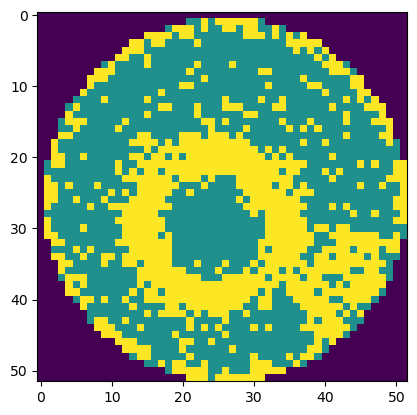

In [4]:
train = data["arr_0"]
print(train[25][25]) # 单通道0-1-2三值图片
print(plt.imshow(train[20010]))
label = data["arr_1"]
#for i in range(50):
#    print(label[i])

In [5]:
print(pd.DataFrame(label).value_counts())
print(pd.DataFrame(label).isnull().sum())

0  1  2  3  4  5  6  7
1  0  1  0  0  0  1  0    2000
0  0  0  0  0  0  0  0    1000
1  0  0  0  1  0  0  0    1000
0  1  1  0  0  0  0  0    1000
                  1  0    1000
            1  0  0  0    1000
                  1  0    1000
1  0  0  0  0  0  0  0    1000
                  1  0    1000
            1  0  1  0    1000
0  1  0  1  1  0  0  0    1000
1  0  0  1  0  0  0  0    1000
                  1  0    1000
            1  0  0  0    1000
                  1  0    1000
      1  0  0  0  0  0    1000
            1  0  0  0    1000
0  1  0  1  1  0  1  0    1000
            0  0  1  0    1000
   0  1  0  0  0  0  0    1000
   1  0  1  0  0  0  0    1000
   0  0  0  0  0  1  0    1000
            1  0  0  0    1000
                  1  0    1000
         1  0  0  0  0    1000
                  1  0    1000
            1  0  0  0    1000
                  1  0    1000
1  0  1  0  1  0  1  0    1000
0  0  1  0  0  0  1  0    1000
            1  0  0  0    1000
                

In [6]:
# # Distribution graphs (histogram/bar graph) of column data
# def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
#     nunique = df.nunique()
#     df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
#     nRow, nCol = df.shape
#     columnNames = list(df)
#     nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
#     plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
#     for i in range(min(nCol, nGraphShown)):
#         plt.subplot(nGraphRow, nGraphPerRow, i + 1)
#         columnDf = df.iloc[:, i]
#         if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
#             valueCounts = columnDf.value_counts()
#             valueCounts.plot.bar()
#         else:
#             columnDf.hist()
#         plt.ylabel('counts')
#         plt.xticks(rotation = 90)
#         plt.title(f'{columnNames[i]} (column {i})')
#     plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
#     plt.show()

# df = pd.DataFrame(train[0])
# plotPerColumnDistribution(df, 1, 1)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, label, test_size = 0.2)

In [8]:
# X_train = X_train.astype(float)
# X_test = X_test.astype(float)

[0 0 1 0 0 0 1 0]
(30412, 8)
(7603, 8)
(30412, 1, 52, 52)
(30412, 52, 52)


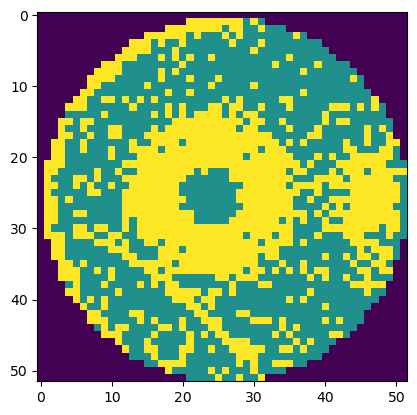

In [9]:
print(y_train[20010])
print(y_train.shape)
print(y_test.shape)
plt.imshow(X_train[0])
print(X_train.reshape(-1, 1, 52,52).shape)
print(X_train.shape)

## Libraries

In [10]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
from sklearn.metrics import classification_report

## VGG

In [11]:
class VGGGrayscale(nn.Module):
    def __init__(self, num_classes=1000, input_size=(224, 224)):
        super(VGGGrayscale, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Additional blocks...
        )

        # Dynamically calculate flattened size
        with torch.no_grad():
            sample_input = torch.randn(1, 1, *input_size)
            flattened_size = self.features(sample_input).view(-1).size(0)

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def VGG(num_classes): 
    model = VGGGrayscale(num_classes=num_classes)
    return model

## MobileNET

In [18]:
## mobilenet_v2
import torch
import torchvision.models as models
import torch.nn as nn

# MobileNetV2 with support for 1-channel input
def mobilenet_V2(num_classes):
    model = models.mobilenet_v2(pretrained=False)  # Load MobileNetV2 architecture

    # Modify the first convolutional layer to accept 1-channel input
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

    # Replace the classifier to match the number of classes in your dataset
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    return model

In [13]:
# MobileNetV3 (Small) with support for 1-channel input
def mobilenet_v3_small_single_channel(num_classes):
    model = models.mobilenet_v3_small(pretrained=False)  # Load MobileNetV3-Small architecture

    # Modify the first convolutional layer to accept 1-channel input
    model.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)

    # Replace the classifier to match the number of classes in your dataset
    model.classifier[3] = nn.Linear(model.classifier[0].out_features, num_classes)

    return model

In [14]:
# MobileNetV3 (Large) with support for 1-channel input
def mobilenet_v3_large_single_channel(num_classes):
    model = models.mobilenet_v3_large(pretrained=False)  # Load MobileNetV3-Large architecture

    # Modify the first convolutional layer to accept 1-channel input
    model.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)

    # Replace the classifier to match the number of classes in your dataset
    model.classifier[3] = nn.Linear(model.classifier[0].out_features, num_classes)

    return model

In [15]:
##  mobilenet_ssd
import torch
from torchvision.models.detection import ssd300_vgg16

# Use pre-built MobileNet-SSD from torchvision

def mobilenet_ssd(num_classes):
    model = ssd300_vgg16(pretrained=False)  # Load SSD300 with VGG16 backbone
    # Replace the head of the model to match the number of classes in your dataset
    model.head.classification_head.num_classes = num_classes

    # Adjust input channels to 1 (grayscale) instead of 3 (RGB)
    model.backbone[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
    return model


## InceptionNext 

In [19]:
class InceptionNextBlock(nn.Module):
    """
    Defines a single InceptionNext block.
    """
    def __init__(self, in_channels, out_channels):
        super(InceptionNextBlock, self).__init__()
        mid_channels = out_channels // 4
        
        # Branch 1: 1x1 Convolution
        self.branch1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0)
        
        # Branch 2: 1x1 Convolution followed by 3x3 Convolution
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        )
        
        # Branch 3: 1x1 Convolution followed by 5x5 Convolution
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=5, stride=1, padding=2)
        )
        
        # Branch 4: MaxPooling followed by 1x1 Convolution
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=1, padding=0)
        )
        
        # Final pointwise convolution to combine all branches
        self.final_conv = nn.Conv2d(mid_channels * 4, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Concatenate outputs from all branches
        x = torch.cat((self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)), dim=1)
        return self.final_conv(x)

class InceptionNext(nn.Module):
    """
    Defines the InceptionNext architecture for grayscale images.
    """
    def __init__(self, num_classes=10):
        super(InceptionNext, self).__init__()
        self.initial_conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)  # Grayscale input (1 channel)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # InceptionNext blocks
        self.block1 = InceptionNextBlock(64, 128)
        self.block2 = InceptionNextBlock(128, 256)
        self.block3 = InceptionNextBlock(256, 512)
        
        # Global Average Pooling and Fully Connected Layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_pool(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def inceptionnext(num_classes): 
    model = InceptionNext(num_classes=num_classes)
    return model

## ConvNext 

In [20]:
from torchvision.models import convnext_tiny

class ConvNeXtGrayscale(nn.Module):
    def __init__(self, num_classes=1000):
        super(ConvNeXtGrayscale, self).__init__()
        # Load pretrained ConvNeXt-Tiny model
        self.convnext = convnext_tiny(pretrained=True)
        
        # Modify the first convolutional layer to accept 1-channel input
        self.convnext.features[0][0] = nn.Conv2d(
            in_channels=1,  # Grayscale input
            out_channels=self.convnext.features[0][0].out_channels,
            kernel_size=self.convnext.features[0][0].kernel_size,
            stride=self.convnext.features[0][0].stride,
            padding=self.convnext.features[0][0].padding,
            bias=False
        )
        
        # Replace the classifier head to match the number of classes
        in_features = self.convnext.classifier[2].in_features
        self.convnext.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.convnext(x)

def convnext(num_classes): 
    model = ConvNeXtGrayscale(num_classes=num_classes)
    return model

## ResNET 

In [22]:


class Bottleneck(nn.Module):
    expansion = 4  # Output channels will be 4 times the input channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet101Modified(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101Modified, self).__init__()
        self.model = models.resnet101(pretrained=True)
        
        # Modify the first convolution layer to accept 1-channel input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


def resnet101(num_classes): 
    model = ResNet101Modified(num_classes=num_classes)
    return model


In [16]:

class ResNet101(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet101, self).__init__()
        self.in_channels = 64

        # Initial Conv and MaxPooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(Bottleneck, 64, blocks=3, stride=1)
        self.layer2 = self._make_layer(Bottleneck, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, blocks=23, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, blocks=3, stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



## BLIP

In [16]:
import torch
import torch.nn as nn
from transformers import BlipProcessor, BlipForImageTextRetrieval
from PIL import Image

class BLIP(nn.Module):
    def __init__(self, num_classes):
        super(BLIP, self).__init__()
        # Load BLIP pre-trained model
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
        self.blip_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")
        
        # Add a custom classifier head
        in_features = self.blip_model.config.hidden_size
        self.classifier = nn.Linear(in_features, num_classes)
        
    def forward(self, x, text=None):
        # Preprocess the input image and text
        inputs = self.processor(images=x, text=text, return_tensors="pt", padding=True)
        
        # Pass input through BLIP model
        outputs = self.blip_model.vision_model(**inputs)
        pooled_output = outputs.pooler_output  # Extract pooled output
        
        # Pass through the custom classifier
        output = self.classifier(pooled_output)
        return output

def blip(num_classes):
    """
    Returns the BLIP model with a classification head.
    Args:
        num_classes (int): Number of output classes.
    """
    model = BLIP(num_classes=num_classes)
    return model

## Clip 

In [35]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3yeb9dz7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3yeb9dz7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [36]:
#Clip
import clip
import torch.nn as nn
import torch

class CustomCLIPModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomCLIPModel, self).__init__()
        # Load the CLIP model
        self.clip_model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")
        
        # Modify the classifier head
        self.classifier = nn.Linear(self.clip_model.visual.output_dim, num_classes)
        
    def forward(self, x):
    # Ensure input is not None and has valid dimensions
        if x is None:
            raise ValueError("Input tensor is None.")
        if len(x.size()) != 4:
            raise ValueError(f"Expected input shape [batch_size, channels, height, width], but got {x.size()}.")
    
    # Convert 1-channel input to 3 channels if necessary
        if x.shape[1] == 1:  # Single channel (grayscale)
            x = x.repeat(1, 3, 1, 1)
    
        print(f"Input shape to encode_image: {x.size()}")  # Debug
    # Pass the image through CLIP's encode_image
        visual_features = self.clip_model.encode_image(x)
        print(f"Encoded features shape: {visual_features.size()}")  # Debug

    # Classify the features
        output = self.classifier(visual_features)
        return output

# Instantiate the model
def clip_model(num_classes):
    model = CustomCLIPModel(num_classes=num_classes)
    return model



## Efficient Net 

In [24]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0

class EfficientNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetGrayscale, self).__init__()
        # Load pretrained EfficientNet-B0 model
        self.efficientnet = efficientnet_b7(pretrained=True)
        
        # Modify the first convolutional layer to accept 1-channel input
        self.efficientnet.features[0][0] = nn.Conv2d(
            in_channels=1,  # Grayscale input
            out_channels=self.efficientnet.features[0][0].out_channels,
            kernel_size=self.efficientnet.features[0][0].kernel_size,
            stride=self.efficientnet.features[0][0].stride,
            padding=self.efficientnet.features[0][0].padding,
            bias=False
        )
        
        # Replace the classifier head to match the number of classes
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)


def efficientnet(num_classes):
    model = EfficientNet(num_classes=num_classes)
    return model

In [25]:
import torch
import torchvision.models as models
import torch.nn as nn

# EfficientNet with support for 1-channel input
def efficientnet_b0(num_classes):
    model = models.efficientnet_b0(pretrained=False)  # Load EfficientNet-B0 architecture

    # Modify the first convolutional layer to accept 1-channel input
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

    # Replace the classifier to match the number of classes in your dataset
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model

In [26]:
import torch
import torchvision.models as models
import torch.nn as nn

# EfficientNet-B7 with support for 1-channel input
def efficientnet_b7(num_classes):
    model = models.efficientnet_b7(pretrained=False)  # Load EfficientNet-B7 architecture

    # Modify the first convolutional layer to accept 1-channel input
    model.features[0][0] = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)

    # Replace the classifier to match the number of classes in your dataset
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model

## AlexNET

In [27]:
import torch.nn as nn
import torch
# from torchsummary import summary

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),  # input[1, 52, 52]  output[128, 52, 52]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 25, 25]

            nn.Conv2d(128, 256, kernel_size=5, padding=10),           # output[256, 41, 41]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[256, 20, 20]

            nn.Conv2d(256, 384, kernel_size=3, padding=1),          # output[384, 20, 20]
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),          # output[384, 20, 20]
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # output[256, 20, 20]
            
            nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=3, stride=2),                  # output[256, 9, 9]
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 9 * 9, 4096), # output[65536, 4096]
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
      #  print(x.shape)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def alexnet(num_classes): 
    model = AlexNet(num_classes=num_classes)
    return model




# net = AlexNet(num_classes=5)
# summary(net.to('cuda'), (3,224,224))
#########################################################################################################################################
# Total params: 62,378,344
# Trainable params: 62,378,344
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): 0.57
# Forward/backward pass size (MB): 11.09
# Params size (MB): 237.95
# Estimated Total Size (MB): 249.62
# ----------------------------------------------------------------
# conv_parameters:  3,747,200
# fnn_parameters:  58,631,144   93% 的参数量

## TransformerNet 

In [28]:
import torch.nn as nn
import torch

class TransformerNet(nn.Module):
    def __init__(self, num_classes=1000, img_size=52, patch_size=4, num_channels=1, d_model=256, nhead=8, num_encoder_layers=6, dim_feedforward=512, dropout=0.1):
        super(TransformerNet, self).__init__()
        
        # Patch embedding layer (similar to Conv2d)
        self.patch_size = patch_size
        self.img_size = img_size
        self.num_patches = (img_size // patch_size) ** 2
        self.d_model = d_model

        self.patch_embed = nn.Conv2d(num_channels, d_model, kernel_size=patch_size, stride=patch_size)
        
        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, self.num_patches, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

        # Dropout and Regularization to reduce overfitting
        self.dropout = nn.Dropout(p=0.3)
        self.batch_norm = nn.BatchNorm1d(d_model)

    def forward(self, x):
        # Extract patches and flatten
        batch_size = x.size(0)
        x = self.patch_embed(x)  # Shape: [batch_size, d_model, H/p, W/p]
        x = x.flatten(2).transpose(1, 2)  # Shape: [batch_size, num_patches, d_model]

        # Add positional encoding
        x = x + self.positional_encoding

        # Pass through Transformer Encoder
        x = self.transformer_encoder(x)  # Shape: [batch_size, num_patches, d_model]

        # Apply BatchNorm and Dropout
        x = x.mean(dim=1)  # Shape: [batch_size, d_model]
        x = self.batch_norm(x)
        x = self.dropout(x)

        # Classification
        x = self.classifier(x)  # Shape: [batch_size, num_classes]

        return x

def transformer_net(num_classes):
    model = TransformerNet(num_classes=num_classes)
    return model

# Example instantiation
# net = TransformerNet(num_classes=5, img_size=52, patch_size=4)
# summary(net.to('cuda'), (1, 52, 52))
#########################################################################################################################################
# Total params: (Dependent on d_model and Transformer configurations)
# Trainable params: (Dependent on d_model and Transformer configurations)
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): Calculated dynamically
# Forward/backward pass size (MB): Calculated dynamically
# Params size (MB): Calculated dynamically
# Estimated Total Size (MB): Calculated dynamically
# ----------------------------------------------------------------


## ViT 

In [29]:
import torch
import torch.nn as nn
from timm.models import create_model
import torch.nn.functional as F

class ViTModel(nn.Module):
    def __init__(self, num_classes=1000, img_size=224):
        super(ViTModel, self).__init__()
        # Convert grayscale to 3-channel
        self.input_adapter = nn.Conv2d(1, 3, kernel_size=1)  # Converts [1, H, W] to [3, H, W]
        
        # Vision Transformer backbone
        self.backbone = create_model(
            'vit_small_patch16_224',  # Pre-trained ViT model from timm
            pretrained=True,
            num_classes=num_classes,
            img_size=img_size,
            in_chans=3,  # Input channels (after adapter)
        )
        self.img_size = img_size

    def forward(self, x):
        # Resize input to match model requirements
        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        x = self.input_adapter(x)  # Convert grayscale to RGB
        x = self.backbone(x)       # Pass through the ViT model
        return x

# Instantiate the model
def vit_model(num_classes):
    model = ViTModel(num_classes=num_classes)
    return model


In [13]:
import torch
import torch.nn as nn
from timm.models import create_model
import torch.nn.functional as F

class ViTModel(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=1000, img_size=224):
        super(ViTModel, self).__init__()
        
        # Convert grayscale to 3-channel
        self.input_adapter = nn.Conv2d(1, 3, kernel_size=1)  # Converts [1, H, W] to [3, H, W]
        
        # Vision Transformer backbone
        self.backbone = create_model(
            model_name,  # Choose ViT variant
            pretrained=True,
            num_classes=num_classes,
            img_size=img_size,
            in_chans=3,  # Input channels (after adapter)
        )
        self.img_size = img_size

    def forward(self, x):
        # Resize input to match model requirements
        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        x = self.input_adapter(x)  # Convert grayscale to RGB
        x = self.backbone(x)       # Pass through the ViT model
        return x

# Function to instantiate different ViT models
def vit_model(variant='base', num_classes=38):
    model_dict = {
        'base': 'vit_base_patch16_224',
        'large': 'vit_large_patch16_224',
        'huge': 'vit_huge_patch14_224'
    }
    model_name = model_dict.get(variant, 'vit_base_patch16_224')
    return ViTModel(model_name=model_name, num_classes=num_classes)



In [13]:

#To adapt the Vision Transformer (ViT) model for few-shot learning, 
#you can integrate a prototype-based approach. 
#Few-shot learning typically involves learning representations 
#from a small number of labeled examples and using them to classify unseen samples.
#Below is an example implementation of a prototype-based few-shot 
#learning model using the ViT backbone:
#Few-Shot Learning Model Code

import torch
import torch.nn as nn
from timm.models import create_model
import torch.nn.functional as F

class FewShotViTModel(nn.Module):
    def __init__(self, num_classes=5, img_size=224):
        super(FewShotViTModel, self).__init__()
        # Convert grayscale to 3-channel
        self.input_adapter = nn.Conv2d(1, 3, kernel_size=1)  # Converts [1, H, W] to [3, H, W]
        
        # Vision Transformer backbone
        self.backbone = create_model(
            'vit_base_patch16_224',  # Pre-trained ViT model from timm
            pretrained=True,
            num_classes=0,  # Exclude the classifier layer
            img_size=img_size,
            in_chans=3,  # Input channels (after adapter)
        )
        self.img_size = img_size
        self.feature_dim = self.backbone.embed_dim  # Output dimension of the ViT feature extractor

    def forward(self, x):
        # Resize input to match model requirements
        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        x = self.input_adapter(x)  # Convert grayscale to RGB
        features = self.backbone(x)  # Extract features using ViT
        return features

class FewShotLearner:
    def __init__(self, model, n_support, n_query):
        """
        Initialize the few-shot learner.

        Args:
        - model: Feature extractor (e.g., ViTModel).
        - n_support: Number of support samples per class.
        - n_query: Number of query samples per class.
        """
        self.model = model
        self.n_support = n_support
        self.n_query = n_query

    def compute_prototypes(self, support_features, support_labels):
        """
        Compute class prototypes from support set.

        Args:
        - support_features: Tensor of shape [n_classes * n_support, feature_dim].
        - support_labels: Tensor of shape [n_classes * n_support].

        Returns:
        - prototypes: Tensor of shape [n_classes, feature_dim].
        """
        prototypes = []
        n_classes = support_labels.unique().size(0)
        for cls in range(n_classes):
            cls_features = support_features[support_labels == cls]
            prototype = cls_features.mean(dim=0)  # Compute mean feature for each class
            prototypes.append(prototype)
        return torch.stack(prototypes, dim=0)

    def classify(self, query_features, prototypes):
        """
        Classify query samples based on prototypes.

        Args:
        - query_features: Tensor of shape [n_classes * n_query, feature_dim].
        - prototypes: Tensor of shape [n_classes, feature_dim].

        Returns:
        - logits: Tensor of shape [n_classes * n_query, n_classes].
        """
        # Compute squared Euclidean distance between query features and prototypes
        distances = torch.cdist(query_features, prototypes, p=2) ** 2
        logits = -distances  # Convert distances to logits (negative for classification)
        return logits

    def forward(self, support_set, support_labels, query_set, query_labels):
        """
        Perform few-shot learning.

        Args:
        - support_set: Tensor of shape [n_classes * n_support, 1, H, W].
        - support_labels: Tensor of shape [n_classes * n_support].
        - query_set: Tensor of shape [n_classes * n_query, 1, H, W].
        - query_labels: Tensor of shape [n_classes * n_query].

        Returns:
        - loss: Few-shot classification loss.
        - accuracy: Few-shot classification accuracy.
        """
        # Extract features
        support_features = self.model(support_set)
        query_features = self.model(query_set)

        # Compute prototypes
        prototypes = self.compute_prototypes(support_features, support_labels)

        # Classify query set
        logits = self.classify(query_features, prototypes)

        # Compute cross-entropy loss
        loss = F.cross_entropy(logits, query_labels)

        # Compute accuracy
        _, predictions = logits.max(dim=1)
        accuracy = (predictions == query_labels).float().mean()

        return loss, accuracy

# Instantiate the model and few-shot learner
def few_shot_vit_model(n_support, n_query, num_classes):
    model = FewShotViTModel(num_classes=num_classes)
    learner = FewShotLearner(model, n_support=n_support, n_query=n_query)
    return learner


### Continue working    

In [12]:
from torch.utils.data import Dataset
import json

class My_Dataset(Dataset):
    
    def __init__(self, X, y, transform = None):
#         self.data_path = data_path
#         self.data = np.load(data_path)
        self.images = X.reshape(-1,1, 52, 52)
        self.one_hot_labels = y
        self.transform = transform
        
        self.classes_dict = {
            "00000000":0,
            "10000000":1,
            "01000000":2,
            "00100000":3,
            "00010000":4,
            "00001000":5,
            "00000100":6,
            "00000010":7,
            "00000001":8,
            "10100000":9,
            "10010000":10,
            "10001000":11,
            "10000010":12,
            "01100000":13,
            "01010000":14,
            "01001000":15,
            "01000010":16,
            "00101000":17,
            "00100010":18,
            "00011000":19,
            "00010010":20,
            "00001010":21,
            "10101000":22,
            "10100010":23,
            "10011000":24,
            "10010010":25,
            "10001010":26,
            "01101000":27,
            "01100010":28,
            "01011000":29,
            "01010010":30,
            "01001010":31,
            "00101010":32,
            "00011010":33,
            "10101010":34,
            "10011010":35,
            "01101010":36,
            "01011010":37,
        }
        
        
        self.classes_num_dict = {}
        
        json_str = json.dumps(self.classes_dict, indent = 4)
        with open( "classes_dict.json" , 'w') as json_file:
            json_file.write(json_str)
        
        
        self.image_labels = []
        self.images_num = []
        
        cnt = 0
        for one_hot_label in self.one_hot_labels:
            cnt += 1
            t = ""
            for ch in one_hot_label:
                if ch == None:
                    t += str(0)
                else:
                    t += str(ch)
            label = self.classes_dict[t]
            if label  not in self.classes_num_dict:
                self.classes_num_dict[label] = 1
            else:
                self.classes_num_dict[label] += 1
            self.image_labels.append(label)
            
        for i in sorted(list(self.classes_num_dict.keys())):
            self.images_num.append(self.classes_num_dict[i])
        
        self.num_classes = len(self.classes_num_dict)
        
        print("num_class：", self.num_classes)
        print("{}/{} images were  found in the dataset.".format(cnt, sum(self.images_num)))
            
        
    def __len__(self):
        return sum(self.images_num)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.image_labels[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label




In [13]:
from torchvision import transforms
# data_transform = {
#     "train": transforms.Compose([transforms.ToTensor(),
#                                  transforms.Resize((224,224)),
#                                  transforms.CenterCrop(224),
#                                  transforms.Normalize((0.5,), (0.5,))]),
#     "val": transforms.Compose([transforms.ToTensor(),
#                                transforms.Resize((224,224)),
#                                transforms.Normalize((0.5,), (0.5,))])
# }
train_dataset = My_Dataset(X_train, y_train)
test_dataset = My_Dataset(X_test, y_test)
val_num = len(test_dataset)

print(type(train_dataset[0][0]))
print(train_dataset[0][0].dtype)
print(X_train.shape)
print(X_test.shape)
# print(train_dataset[0][0])

num_class： 38
30412/30412 images were  found in the dataset.
num_class： 38
7603/7603 images were  found in the dataset.
<class 'numpy.ndarray'>
int32
(30412, 52, 52)
(7603, 52, 52)


In [14]:
from torch.utils.data import DataLoader

"""
dataloader自动转化为torch.int32类型数据，但训练时需要的是float类型计算
"""
batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=2, drop_last=False)
print(len(train_loader))
print(len(test_loader))

#iters = iter(train_loader)
#a, b = next(iters)
#print(type(a))
#print(a.dtype) 
#print(b.shape)

# for data in train_loader:
#     imgs, lab = data
#     print(imgs.dtype)
#     print(lab.dtype)

476
1901



1、实例化模型   
2、定义损失函数，优化器   
3、定义迭代次数   
4、查询是否保存模型参数   
 

In [15]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm import tqdm
import sys
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
from torchsummary import summary
#net = ResNet101Modified(num_classes=5)
net =vit_model(num_classes=38)
summary(net.to('cuda'), (1,224,224))


#================================================================
#Total params: 42,510,405
#Trainable params: 42,510,405
#Non-trainable params: 0
#----------------------------------------------------------------
#Input size (MB): 0.57
#Forward/backward pass size (MB): 429.72
#Params size (MB): 162.16
#Estimated Total Size (MB): 592.46
#----------------------------------------------------------------

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]               6
            Conv2d-2          [-1, 768, 14, 14]         590,592
          Identity-3             [-1, 196, 768]               0
        PatchEmbed-4             [-1, 196, 768]               0
           Dropout-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
          Identity-7             [-1, 197, 768]               0
         LayerNorm-8             [-1, 197, 768]           1,536
            Linear-9            [-1, 197, 2304]       1,771,776
         Identity-10          [-1, 12, 197, 64]               0
         Identity-11          [-1, 12, 197, 64]               0
           Linear-12             [-1, 197, 768]         590,592
          Dropout-13             [-1, 197, 768]               0
        Attention-14             [-1, 1

### Without Confusion Matrix

In [19]:
## Without Confusion Matrix 
# %%time

# from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
#Select the Model to train 
#net = VGG(num_classes=38)
#net = inceptionnext(num_classes=38)
#net = convnext(num_classes=38)
net = resnet50(num_classes=38)
#net = alexnet(num_classes=38)
net.to(device)
# print(summary(net, (1,52,52)))

loss_function = CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=3e-5)
epochs = 10


best_acc = 0.0
for epoch in range(epochs):
    ############################train训练#############################################
    net.train() # 声明正在训练
    acc_num = torch.zeros(1).to(device) # 初始化，用于计算训练过程中预测正确的数量
    sample_num = 0 # 初始化，用于记录当前迭代中，已经计算了多少个样本
    train_bar = tqdm(train_loader, file=sys.stdout, ncols=100)
    for step, data in enumerate(train_bar):
        images, labels = data
        sample_num += images.shape[0] # 【batch, channel, height, width】
        optimizer.zero_grad()
#         print(images.to(device).device)
        images = images.float()
#。     print(images.shape)
        outputs = net(images.to(device)) # 输出维度：[batch_size, num_classes]，且输入需要是一个张量，输出是个张量
        pred_class = torch.max(outputs, dim=1)[1]  # torch.max返回一个tuple，第一个是最大的值，第二个是最大的值的索引
        acc_num += torch.eq(pred_class, labels.to(device)).sum() # 这一批数据有多少个预测正确的个数加到acc_num
        
        loss = loss_function(outputs, labels.to(device)) # 输出的也是张量，但是label不是
        loss.backward() # 自动求导
        optimizer.step() # 梯度下降
        
        train_acc = acc_num.item() / sample_num
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch+1, epochs, loss) # 一批训练完就更新准确率
     ########################validate验证############################################
    net.eval() # 固定模型中所有参数
    acc_num = 0.0
    with torch.no_grad(): # 固定梯度
        for val_data in test_loader:
            val_images, val_labels = val_data
            val_images = val_images.float()
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc_num += torch.eq(predict_y, val_labels.to(device)).sum().item()
    val_accurate = acc_num / val_num
    print('[epoch %d] train_loss: %.3f train_acc: %.3f val_accuracy: %.3f' % (epoch+1, loss, train_acc, val_accurate))
    
    if val_accurate > best_acc:
        best_acc = val_accurate
        
    train_acc = 0.0 # 清空
    val_accurate = 0.0

print("Finished Training")

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

train epoch[1/10] loss:2.236: 100%|███████████████████████████████| 476/476 [00:52<00:00,  9.08it/s]
[epoch 1] train_loss: 2.236 train_acc: 0.489 val_accuracy: 0.790
train epoch[2/10] loss:1.675: 100%|███████████████████████████████| 476/476 [00:48<00:00,  9.89it/s]
[epoch 2] train_loss: 1.675 train_acc: 0.846 val_accuracy: 0.891
train epoch[3/10] loss:0.431: 100%|███████████████████████████████| 476/476 [00:48<00:00,  9.90it/s]
[epoch 3] train_loss: 0.431 train_acc: 0.913 val_accuracy: 0.903
train epoch[4/10] loss:0.609: 100%|███████████████████████████████| 476/476 [00:47<00:00,  9.99it/s]
[epoch 4] train_loss: 0.609 train_acc: 0.939 val_accuracy: 0.922
train epoch[5/10] loss:0.206: 100%|███████████████████████████████| 476/476 [00:47<00:00, 10.03it/s]
[epoch 5] train_loss: 0.206 train_acc: 0.959 val_accuracy: 0.925
train epoch[6/10] loss:0.398: 100%|███████████████████████████████| 476/476 [00:47<00:00, 10.00it/s]
[epoch 6] train_loss: 0.398 train_acc: 0.968 val_accuracy: 0.918
trai

NameError: name 'all_labels' is not defined

In [ ]:
Results with the SOTA on the classification task 

ViT Model
train_loss: 0.000 train_acc: 0.997 val_accuracy: 0.982

InceptionNext 
train_loss: 1.238 train_acc: 0.590 val_accuracy: 0.592

convnext
train_loss: 0.003 train_acc: 0.984 val_accuracy: 0.895

ResNet 152 
 train_loss: 0.019 train_acc: 0.996 val_accuracy: 0.953

ResNet 101 
 train_loss: 0.058 train_acc: 0.995 val_accuracy: 0.954

ResNet 50 
 train_loss: 0.003 train_acc: 0.978 val_accuracy: 0.966

ResNet18 
 train_loss: 0.057 train_acc: 0.994 val_accuracy: 0.944

AlexNet 
 train_loss: 0.006 train_acc: 0.982 val_accuracy: 0.969

Efficient_B0
train_loss: 0.761 train_acc: 0.963 val_accuracy: 0.882

EfficientNet_B7
train_loss: 0.631 train_acc: 0.966 val_accuracy: 0.909

MobileNet_v3
train_loss: 0.092 train_acc: 0.934 val_accuracy: 0.825

MobileNet_v3_large
train_loss: 0.971 train_acc: 0.977 val_accuracy: 0.741

In [45]:
import torch
import torchvision.transforms as transforms
import numpy as np

# Create dummy grayscale data as a NumPy array
images_np = np.random.randn(64, 1, 52, 52)  # Example batch of grayscale images

# Convert NumPy array to PyTorch tensor
images = torch.tensor(images_np, dtype=torch.float32)

# Duplicate the single grayscale channel to create a pseudo-RGB image
images = images.repeat(1, 3, 1, 1)  # Duplicate along the channel dimension

# Define preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (expected by CLIP and similar models)
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),  # CLIP normalization mean
                         std=(0.26862954, 0.26130258, 0.27577711))   # CLIP normalization std
])

# Apply preprocessing to all images in the batch
images = torch.stack([preprocess(image) for image in images])

# Move images to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = images.to(device)

# Assume `net` is your model
net.to(device)

# Perform a forward pass
outputs = net(images)
print(outputs.shape)  # Expected: [64, num_classes]


torch.Size([64, 38])


In [48]:
import clip
import torch.nn as nn
import torch

class CustomCLIPModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomCLIPModel, self).__init__()
        # Load the CLIP model
        self.clip_model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")
        
        # Modify the classifier head
        self.classifier = nn.Linear(self.clip_model.visual.output_dim, num_classes)
        
    def forward(self, x):
        # Use the visual encoder of CLIP
        visual_features = self.clip_model.encode_image(x)
        
        # Ensure visual_features has the same dtype as classifier weights
        visual_features = visual_features.to(self.classifier.weight.dtype)
        
        output = self.classifier(visual_features)
        return output

# Instantiate the model
def clip_model(num_classes):
    model = CustomCLIPModel(num_classes=num_classes)
    return model



### Train and Evaluate the Model 

In [22]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
#import clip
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume `net` is your model, already initialized and moved to `device`
# Assume `train_loader` and `test_loader` are your DataLoader objects

# device = "cpu"
#Select the Model to train 
net = VGG(num_classes=38)
#net = inceptionnext(num_classes=38)
#net = convnext(num_classes=38)
#net = resnet101(num_classes=38)
#net = alexnet(num_classes=38)
#net = efficientnet_b7(num_classes=38)
#net = clip_model(num_classes=38)
#net = blip(num_classes=38)
#net = mobilenet_V2(num_classes=38)
#net = transformer_net(num_classes=38)
#net = vit_model(num_classes = 38)
#net = few_shot_vit_model(n_support=5, n_query=10, num_classes=5)
#net = mobilenet_v3_small_single_channel(num_classes=38)
#net = mobilenet_v3_large_single_channel(num_classes=38)


net.to(device)
# Loss and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-5)

# Training parameters
epochs = 30
best_acc = 0.0

# Training loop
for epoch in range(epochs):
    net.train()
    acc_num = torch.zeros(1).to(device)
    sample_num = 0
    train_bar = tqdm(train_loader, file=sys.stdout, ncols=100)

    for step, data in enumerate(train_bar):
        images, labels = data
        images, labels = images.float().to(device), labels.to(device)
        sample_num += images.shape[0]

        optimizer.zero_grad()
        outputs = net(images)
        pred_class = torch.max(outputs, dim=1)[1]
        acc_num += torch.eq(pred_class, labels).sum()

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_acc = acc_num.item() / sample_num
        train_bar.desc = f"train epoch[{epoch + 1}/{epochs}] loss:{loss:.3f}"

    # Validation
    net.eval()
    acc_num = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for val_data in test_loader:
            val_images, val_labels = val_data
            val_images, val_labels = val_images.float().to(device), val_labels.to(device)
            outputs = net(val_images)
            predict_y = torch.max(outputs, dim=1)[1]

            acc_num += torch.eq(predict_y, val_labels).sum().item()
            all_labels.extend(val_labels.cpu().numpy())
            all_preds.extend(predict_y.cpu().numpy())

    val_accurate = acc_num / len(test_loader.dataset)
    print(f"[epoch {epoch + 1}] train_loss: {loss:.3f} train_acc: {train_acc:.3f} val_accuracy: {val_accurate:.3f}")

    # Save best model
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), "best_model.pth")

print("Finished Training")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap="Blues", xticklabels=range(len(conf_matrix)),
            yticklabels=range(len(conf_matrix)))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.25 GiB. GPU 0 has a total capacity of 8.00 GiB of which 6.92 GiB is free. Of the allocated memory 295.00 KiB is allocated by PyTorch, and 1.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:
import torch
torch.cuda.empty_cache()

In [50]:
import torch
import torch.nn as nn
from timm.models import create_model
import torch.nn.functional as F

class FewShotViTModel(nn.Module):
    def __init__(self, num_classes=5, img_size=224):
        super(FewShotViTModel, self).__init__()
        # Convert grayscale to 3-channel
        self.input_adapter = nn.Conv2d(1, 3, kernel_size=1)  # Converts [1, H, W] to [3, H, W]
        
        # Vision Transformer backbone
        self.backbone = create_model(
            'vit_base_patch16_224',  # Pre-trained ViT model from timm
            pretrained=True,
            num_classes=0,  # Exclude the classifier layer
            img_size=img_size,
            in_chans=3,  # Input channels (after adapter)
        )
        self.img_size = img_size
        self.feature_dim = self.backbone.embed_dim  # Output dimension of the ViT feature extractor

    def forward(self, x):
        # Resize input to match model requirements
        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        x = self.input_adapter(x)  # Convert grayscale to RGB
        features = self.backbone(x)  # Extract features using ViT
        return features

class FewShotLearner:
    def __init__(self, model, n_support, n_query):
        """
        Initialize the few-shot learner.

        Args:
        - model: Feature extractor (e.g., ViTModel).
        - n_support: Number of support samples per class.
        - n_query: Number of query samples per class.
        """
        self.model = model
        self.n_support = n_support
        self.n_query = n_query

    def compute_prototypes(self, support_features, support_labels):
        """
        Compute class prototypes from support set.

        Args:
        - support_features: Tensor of shape [n_classes * n_support, feature_dim].
        - support_labels: Tensor of shape [n_classes * n_support].

        Returns:
        - prototypes: Tensor of shape [n_classes, feature_dim].
        """
        prototypes = []
        n_classes = support_labels.unique().size(0)
        for cls in range(n_classes):
            cls_features = support_features[support_labels == cls]
            prototype = cls_features.mean(dim=0)  # Compute mean feature for each class
            prototypes.append(prototype)
        return torch.stack(prototypes, dim=0)

    def classify(self, query_features, prototypes):
        """
        Classify query samples based on prototypes.

        Args:
        - query_features: Tensor of shape [n_classes * n_query, feature_dim].
        - prototypes: Tensor of shape [n_classes, feature_dim].

        Returns:
        - logits: Tensor of shape [n_classes * n_query, n_classes].
        """
        # Compute squared Euclidean distance between query features and prototypes
        distances = torch.cdist(query_features, prototypes, p=2) ** 2
        logits = -distances  # Convert distances to logits (negative for classification)
        return logits

    def forward(self, support_set, support_labels, query_set, query_labels):
        """
        Perform few-shot learning.

        Args:
        - support_set: Tensor of shape [n_classes * n_support, 1, H, W].
        - support_labels: Tensor of shape [n_classes * n_support].
        - query_set: Tensor of shape [n_classes * n_query, 1, H, W].
        - query_labels: Tensor of shape [n_classes * n_query].

        Returns:
        - loss: Few-shot classification loss.
        - accuracy: Few-shot classification accuracy.
        """
        # Extract features
        support_features = self.model(support_set)
        query_features = self.model(query_set)

        # Compute prototypes
        prototypes = self.compute_prototypes(support_features, support_labels)

        # Classify query set
        logits = self.classify(query_features, prototypes)

        # Compute cross-entropy loss
        loss = F.cross_entropy(logits, query_labels)

        # Compute accuracy
        _, predictions = logits.max(dim=1)
        accuracy = (predictions == query_labels).float().mean()

        return loss, accuracy

# Instantiate the model and few-shot learner
def few_shot_vit_model(n_support=5, n_query=15, num_classes=5):
    model = FewShotViTModel(num_classes=num_classes)
    learner = FewShotLearner(model, n_support=n_support, n_query=n_query)
    return learner

# Example usage
if __name__ == "__main__":
    # Create dummy support and query sets
    n_classes = 10
    n_support = 5
    n_query = 10
    img_size = 52

    learner = few_shot_vit_model(n_support=n_support, n_query=n_query, num_classes=n_classes)

    support_set = torch.randn(n_classes * n_support, 1, img_size, img_size)
    support_labels = torch.arange(n_classes).repeat_interleave(n_support)
    query_set = torch.randn(n_classes * n_query, 1, img_size, img_size)
    query_labels = torch.arange(n_classes).repeat_interleave(n_query)

    # Forward pass
    loss, accuracy = learner.forward(support_set, support_labels, query_set, query_labels)
    print(f"Loss: {loss.item():.4f}, Accuracy: {accuracy.item() * 100:.2f}%")


Loss: 32.3050, Accuracy: 11.00%


In [ ]:
if __name__ == "__main__":
    # Define the few-shot learning parameters
    n_classes = 11
    n_support = 15
    n_query = 11
    img_size = 52

    # Instantiate the model and few-shot learner
    learner = few_shot_vit_model(n_support=n_support, n_query=n_query, num_classes=n_classes)

    # Create dummy support and query sets
    support_set = torch.randn(n_classes * n_support, 1, img_size, img_size)
    support_labels = torch.arange(n_classes).repeat_interleave(n_support)
    query_set = torch.randn(n_classes * n_query, 1, img_size, img_size)
    query_labels = torch.arange(n_classes).repeat_interleave(n_query)

    # Loss function
    loss_function = torch.nn.CrossEntropyLoss()

    # Optimizer (Use parameters from the underlying ViT model)
    optimizer = torch.optim.Adam(learner.model.parameters(), lr=3e-5)

    # Forward pass
    loss, accuracy = learner.forward(support_set, support_labels, query_set, query_labels)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Loss: {loss.item():.4f}, Accuracy: {accuracy.item() * 100:.2f}%")


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch.nn.functional as F

# Training loop with evaluation metrics
def train_few_shot_model(learner, support_set, support_labels, query_set, query_labels, num_epochs=10, lr=3e-5):
    # Loss and optimizer
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(learner.model.parameters(), lr=lr)

    for epoch in range(1, num_epochs + 1):
        # Forward pass
        optimizer.zero_grad()
        loss, _ = learner.forward(support_set, support_labels, query_set, query_labels)
        loss.backward()
        optimizer.step()

        # Evaluate on query set
        learner.model.eval()
        with torch.no_grad():
            query_logits = learner.model(query_set)
            query_preds = F.softmax(query_logits, dim=1).argmax(dim=1)

        # Calculate metrics
        accuracy = accuracy_score(query_labels.cpu(), query_preds.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(
            query_labels.cpu(), query_preds.cpu(), average=None, labels=torch.unique(query_labels).cpu()
        )

        # Print metrics
        print(f"[Epoch {epoch}]")
        print(f"Loss: {loss.item():.4f}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        for i, cls in enumerate(torch.unique(query_labels).cpu().numpy()):
            print(f"Class {cls}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")
        print("-" * 50)

        learner.model.train()

# Example usage
if __name__ == "__main__":
    # Define the few-shot learning parameters
    n_classes = 30
    n_support = 500
    n_query = 15
    img_size = 52
    num_epochs = 30  # Vary the number of epochs here

    # Instantiate the model and few-shot learner
    learner = few_shot_vit_model(n_support=n_support, n_query=n_query, num_classes=n_classes)

    # Create dummy support and query sets
    support_set = torch.randn(n_classes * n_support, 1, img_size, img_size)
    support_labels = torch.arange(n_classes).repeat_interleave(n_support)
    query_set = torch.randn(n_classes * n_query, 1, img_size, img_size)
    query_labels = torch.arange(n_classes).repeat_interleave(n_query)

    # Train and evaluate the model
    train_few_shot_model(
        learner, support_set, support_labels, query_set, query_labels, num_epochs=num_epochs, lr=3e-5
    )


In [ ]:
InceptionNext 
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       199
           1     0.9052    0.9550    0.9294       200
           2     0.6786    0.7238    0.7005       210
           3     0.6531    0.7767    0.7095       206
           4     0.6792    0.8534    0.7564       191
           5     0.6500    0.6566    0.6533       198
           6     0.9032    0.9032    0.9032        31
           7     0.7980    0.8571    0.8265       189
           8     0.9167    0.8902    0.9032       173
           9     0.6402    0.5738    0.6052       183
          10     0.5294    0.8844    0.6623       173
          11     0.6457    0.5355    0.5855       211
          12     0.7542    0.8683    0.8073       205
          13     0.4869    0.4581    0.4721       203
          14     0.3807    0.8152    0.5190       184
          15     0.5429    0.1900    0.2815       200
          16     0.5628    0.6190    0.5896       210
          17     0.7465    0.5436    0.6291       195
          18     0.6611    0.5385    0.5935       221
          19     0.4500    0.7844    0.5719       218
          20     0.6667    0.6597    0.6632       191
          21     0.5822    0.7294    0.6475       170
          22     0.5411    0.3780    0.4451       209
          23     0.6334    0.7530    0.6881       413
          24     0.4392    0.4716    0.4548       176
          25     0.6193    0.5317    0.5722       205
          26     0.6136    0.6618    0.6368       204
          27     0.6242    0.5052    0.5584       194
          28     0.4734    0.3524    0.4040       227
          29     0.5000    0.2362    0.3208       199
          30     0.4244    0.3782    0.4000       193
          31     0.4744    0.7475    0.5804       198
          32     0.7013    0.5870    0.6391       184
          33     0.7115    0.1602    0.2615       231
          34     0.5403    0.3472    0.4227       193
          35     0.6111    0.4692    0.5308       211
          36     0.5410    0.6804    0.6027       194
          37     0.7711    0.6066    0.6790       211

    accuracy                         0.6154      7603
   macro avg     0.6330    0.6232    0.6107      7603
weighted avg     0.6269    0.6154    0.6031      7603


In [ ]:
ViT 
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       196
           1     0.9909    0.9954    0.9932       219
           2     0.9950    0.9950    0.9950       199
           3     1.0000    0.9756    0.9877       205
           4     0.9690    0.9955    0.9821       220
           5     0.9951    0.9855    0.9903       207
           6     0.9375    1.0000    0.9677        30
           7     0.9896    1.0000    0.9948       190
           8     1.0000    0.9881    0.9940       168
           9     0.9764    0.9673    0.9718       214
          10     0.9907    0.9727    0.9817       220
          11     0.9713    0.9951    0.9831       204
          12     0.9724    0.9679    0.9701       218
          13     0.9948    0.9697    0.9821       198
          14     0.9944    0.9890    0.9917       181
          15     0.9752    0.9949    0.9850       198
          16     0.9784    1.0000    0.9891       181
          17     0.9955    1.0000    0.9977       219
          18     1.0000    0.9848    0.9923       197
          19     0.9707    0.9755    0.9731       204
          20     0.9808    0.9903    0.9855       206
          21     0.9757    0.9901    0.9829       203
          22     0.9567    0.9803    0.9684       203
          23     0.9949    0.9774    0.9861       399
          24     0.9487    0.9893    0.9686       187
          25     0.9831    1.0000    0.9915       175
          26     0.9467    0.9357    0.9412       171
          27     0.9722    0.9887    0.9804       177
          28     0.9806    0.9758    0.9782       207
          29     0.9531    1.0000    0.9760       183
          30     0.9710    1.0000    0.9853       201
          31     0.9848    0.9750    0.9799       200
          32     1.0000    0.9724    0.9860       217
          33     0.9657    0.9704    0.9681       203
          34     0.9572    0.9521    0.9547       188
          35     0.9950    0.9709    0.9828       206
          36     1.0000    0.9482    0.9734       193
          37     0.9856    0.9537    0.9694       216

    accuracy                         0.9816      7603
   macro avg     0.9802    0.9822    0.9811      7603
weighted avg     0.9818    0.9816    0.9816      7603


EfficientNet_B0
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       197
           1     0.9248    0.9766    0.9500       214
           2     0.8558    0.9735    0.9109       189
           3     0.9420    0.9548    0.9483       221
           4     0.9116    0.9655    0.9378       203
           5     0.9196    0.8472    0.8819       216
           6     0.9167    0.9706    0.9429        34
           7     0.9200    0.9952    0.9561       208
           8     0.9941    0.9655    0.9796       174
           9     0.9388    0.8976    0.9177       205
          10     0.8200    0.9903    0.8972       207
          11     0.8756    0.8756    0.8756       201
          12     0.9021    0.9815    0.9401       216
          13     0.7608    0.8503    0.8030       187
          14     0.8465    0.9146    0.8792       199
          15     0.8476    0.7354    0.7875       189
          16     0.8163    0.9479    0.8772       211
          17     0.9204    0.9391    0.9296       197
          18     0.9100    0.9014    0.9057       213
          19     0.8907    0.8670    0.8787       188
          20     0.8644    0.9401    0.9007       217
          21     0.8436    0.9223    0.8812       193
          22     0.8182    0.8308    0.8244       195
          23     0.9442    0.9690    0.9564       419
          24     0.8246    0.7540    0.7877       187
          25     0.8984    0.8889    0.8936       189
          26     0.9026    0.8627    0.8822       204
          27     0.9714    0.8543    0.9091       199
          28     0.8081    0.7583    0.7824       211
          29     0.9409    0.9358    0.9383       187
          30     0.7854    0.8269    0.8056       208
          31     0.7790    0.8011    0.7899       176
          32     0.9427    0.7708    0.8481       192
          33     0.8743    0.8520    0.8630       196
          34     0.9007    0.7056    0.7913       180
          35     0.8662    0.7861    0.8242       173
          36     0.9221    0.7396    0.8208       192
          37     0.8950    0.8287    0.8606       216

    accuracy                         0.8861      7603
   macro avg     0.8867    0.8836    0.8831      7603
weighted avg     0.8880    0.8861    0.8851      7603


EfficientNet_B7
Classification Report:
              precision    recall  f1-score   support

           0     0.9949    1.0000    0.9975       197
           1     0.9264    1.0000    0.9618       214
           2     0.8832    1.0000    0.9380       189
           3     0.9241    0.9367    0.9303       221
           4     0.9132    0.9852    0.9479       203
           5     0.8642    0.9722    0.9150       216
           6     1.0000    0.8235    0.9032        34
           7     0.9367    0.9952    0.9650       208
           8     0.9663    0.9885    0.9773       174
           9     0.9505    0.9366    0.9435       205
          10     0.8922    1.0000    0.9431       207
          11     0.8468    0.9353    0.8889       201
          12     0.9181    0.9861    0.9509       216
          13     0.9364    0.8663    0.9000       187
          14     0.8905    0.9397    0.9144       199
          15     0.8652    0.8148    0.8392       189
          16     0.8432    0.9431    0.8904       211
          17     0.8990    0.9492    0.9235       197
          18     0.9590    0.8779    0.9167       213
          19     0.8995    0.9043    0.9019       188
          20     0.9298    0.9770    0.9528       217
          21     0.9412    0.8290    0.8815       193
          22     0.8907    0.8359    0.8624       195
          23     0.9757    0.9594    0.9675       419
          24     0.8548    0.8503    0.8525       187
          25     0.9133    0.9471    0.9299       189
          26     0.9167    0.8088    0.8594       204
          27     0.9786    0.9196    0.9482       199
          28     0.8356    0.8673    0.8512       211
          29     0.9405    0.9305    0.9355       187
          30     0.8043    0.9087    0.8533       208
          31     0.8210    0.7557    0.7870       176
          32     0.9682    0.7917    0.8711       192
          33     0.9110    0.8878    0.8992       196
          34     0.9643    0.7500    0.8437       180
          35     0.8686    0.8786    0.8736       173
          36     0.9856    0.7135    0.8278       192
          37     0.8533    0.8889    0.8707       216

    accuracy                         0.9094      7603
   macro avg     0.9122    0.9041    0.9057      7603
weighted avg     0.9118    0.9094    0.9084      7603

MobileNet_v2 
Classification Report:
              precision    recall  f1-score   support

           0     0.9220    0.9793    0.9497       193
           1     0.3739    0.4195    0.3954       205
           2     0.3298    0.3246    0.3272       191
           3     0.3698    0.3679    0.3688       193
           4     0.3906    0.4573    0.4213       199
           5     0.2194    0.2667    0.2407       195
           6     0.9444    0.9189    0.9315        37
           7     0.3640    0.4505    0.4027       202
           8     0.8400    0.7159    0.7730       176
           9     0.2727    0.3015    0.2864       199
          10     0.3486    0.3800    0.3636       200
          11     0.1415    0.1667    0.1531       180
          12     0.2609    0.2621    0.2615       206
          13     0.2679    0.2333    0.2494       240
          14     0.2562    0.2081    0.2297       197
          15     0.2208    0.2684    0.2423       190
          16     0.2657    0.2171    0.2390       175
          17     0.2584    0.2727    0.2654       198
          18     0.1872    0.2088    0.1974       182
          19     0.2470    0.2864    0.2652       213
          20     0.2515    0.2069    0.2270       203
          21     0.2925    0.3163    0.3039       196
          22     0.1493    0.1675    0.1579       197
          23     0.6628    0.8593    0.7484       398
          24     0.1934    0.2047    0.1989       171
          25     0.2010    0.1872    0.1939       219
          26     0.2830    0.3077    0.2948       195
          27     0.2465    0.1832    0.2102       191
          28     0.2191    0.1875    0.2021       208
          29     0.3538    0.3538    0.3538       212
          30     0.2418    0.1789    0.2056       246
          31     0.2616    0.2206    0.2394       204
          32     0.2353    0.2041    0.2186       196
          33     0.3416    0.2594    0.2949       212
          34     0.2182    0.1818    0.1983       198
          35     0.3185    0.2358    0.2710       212
          36     0.2450    0.2722    0.2579       180
          37     0.3333    0.2938    0.3123       194

    accuracy                         0.3289      7603
   macro avg     0.3297    0.3296    0.3277      7603
weighted avg     0.3239    0.3289    0.3241      7603

MobileNet_v3
Classification Report:
              precision    recall  f1-score   support

           0     0.9947    1.0000    0.9973       187
           1     0.8806    0.9465    0.9124       187
           2     0.8455    0.8995    0.8717       219
           3     0.8595    0.8548    0.8571       186
           4     0.8915    0.9220    0.9065       205
           5     0.7864    0.8872    0.8337       195
           6     0.9688    0.9394    0.9538        33
           7     0.8899    0.9510    0.9194       204
           8     0.9774    0.9665    0.9719       179
           9     0.8232    0.8030    0.8130       203
          10     0.8278    0.8238    0.8258       210
          11     0.7857    0.7933    0.7895       208
          12     0.8519    0.9154    0.8825       201
          13     0.7018    0.7688    0.7338       199
          14     0.7864    0.8020    0.7941       202
          15     0.7486    0.6931    0.7198       189
          16     0.8000    0.8528    0.8256       197
          17     0.8670    0.8069    0.8359       202
          18     0.8647    0.8483    0.8565       211
          19     0.8293    0.8416    0.8354       202
          20     0.8685    0.8981    0.8831       206
          21     0.7655    0.8737    0.8160       198
          22     0.7680    0.7413    0.7544       201
          23     0.8700    0.9700    0.9173       400
          24     0.7316    0.7380    0.7348       229
          25     0.8830    0.7511    0.8117       221
          26     0.8142    0.7340    0.7720       203
          27     0.7362    0.7317    0.7339       164
          28     0.7861    0.7248    0.7542       218
          29     0.8978    0.8068    0.8499       207
          30     0.7561    0.7908    0.7731       196
          31     0.7437    0.7957    0.7688       186
          32     0.7969    0.7688    0.7826       199
          33     0.8087    0.7590    0.7831       195
          34     0.7811    0.7135    0.7458       185
          35     0.7795    0.7488    0.7638       203
          36     0.8385    0.6959    0.7606       194
          37     0.8375    0.7486    0.7906       179

    accuracy                         0.8249      7603
   macro avg     0.8275    0.8239    0.8245      7603
weighted avg     0.8254    0.8249    0.8239      7603


MobileNet_v3_large 
Classification Report:
              precision    recall  f1-score   support

           0     0.9947    1.0000    0.9973       187
           1     0.8646    0.8877    0.8760       187
           2     0.7351    0.8995    0.8090       219
           3     0.8519    0.7419    0.7931       186
           4     0.8173    0.8293    0.8232       205
           5     0.7772    0.7333    0.7546       195
           6     0.9118    0.9394    0.9254        33
           7     0.8125    0.9559    0.8784       204
           8     0.9657    0.9441    0.9548       179
           9     0.8726    0.6749    0.7611       203
          10     0.8201    0.7381    0.7769       210
          11     0.7475    0.7115    0.7291       208
          12     0.8037    0.8557    0.8289       201
          13     0.6786    0.5729    0.6213       199
          14     0.7348    0.6584    0.6945       202
          15     0.6140    0.5556    0.5833       189
          16     0.6498    0.7157    0.6812       197
          17     0.8272    0.6634    0.7363       202
          18     0.7467    0.8104    0.7773       211
          19     0.6963    0.7376    0.7163       202
          20     0.7635    0.7524    0.7579       206
          21     0.7261    0.8434    0.7804       198
          22     0.6983    0.6219    0.6579       201
          23     0.8348    0.9600    0.8930       400
          24     0.6535    0.6507    0.6521       229
          25     0.7788    0.7647    0.7717       221
          26     0.7436    0.7143    0.7286       203
          27     0.5556    0.5488    0.5521       164
          28     0.6417    0.5505    0.5926       218
          29     0.6468    0.7874    0.7102       207
          30     0.6497    0.5867    0.6166       196
          31     0.6313    0.6075    0.6192       186
          32     0.7059    0.7236    0.7146       199
          33     0.6435    0.7590    0.6965       195
          34     0.6481    0.5676    0.6052       185
          35     0.6758    0.7291    0.7014       203
          36     0.6768    0.5722    0.6201       194
          37     0.6127    0.6983    0.6527       179

    accuracy                         0.7406      7603
   macro avg     0.7423    0.7385    0.7379      7603
weighted avg     0.7413    0.7406    0.7383      7603

ConvNext 
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9849    0.9924       199
           1     0.9146    0.9100    0.9123       200
           2     0.9175    0.8476    0.8812       210
           3     0.9179    0.9223    0.9201       206
           4     0.9442    0.9738    0.9588       191
           5     0.8394    0.9242    0.8798       198
           6     0.9355    0.9355    0.9355        31
           7     0.9179    0.9471    0.9323       189
           8     0.9884    0.9884    0.9884       173
           9     0.9268    0.8306    0.8761       183
          10     0.9286    0.9769    0.9521       173
          11     0.8772    0.9479    0.9112       211
          12     0.9208    0.9073    0.9140       205
          13     0.8693    0.8522    0.8607       203
          14     0.8817    0.8913    0.8865       184
          15     0.9149    0.8600    0.8866       200
          16     0.8485    0.9333    0.8889       210
          17     0.8696    0.8205    0.8443       195
          18     0.9073    0.8416    0.8732       221
          19     0.8973    0.9220    0.9095       218
          20     0.8386    0.9791    0.9034       191
          21     0.8295    0.8588    0.8439       170
          22     0.9274    0.7943    0.8557       209
          23     0.9375    0.9806    0.9586       413
          24     0.9412    0.8182    0.8754       176
          25     0.9286    0.9512    0.9398       205
          26     0.9133    0.8775    0.8950       204
          27     0.9833    0.9124    0.9465       194
          28     0.8698    0.8238    0.8462       227
          29     0.9444    0.9397    0.9421       199
          30     0.8281    0.9482    0.8841       193
          31     0.8550    0.8636    0.8593       198
          32     0.8642    0.7609    0.8092       184
          33     0.8800    0.8571    0.8684       231
          34     0.8579    0.8446    0.8512       193
          35     0.8283    0.9147    0.8694       211
          36     0.8259    0.8557    0.8405       194
          37     0.9029    0.8815    0.8921       211

    accuracy                         0.8978      7603
   macro avg     0.8993    0.8968    0.8970      7603
weighted avg     0.8992    0.8978    0.8974      7603

InceptionNext 
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       199
           1     0.9052    0.9550    0.9294       200
           2     0.6786    0.7238    0.7005       210
           3     0.6531    0.7767    0.7095       206
           4     0.6792    0.8534    0.7564       191
           5     0.6500    0.6566    0.6533       198
           6     0.9032    0.9032    0.9032        31
           7     0.7980    0.8571    0.8265       189
           8     0.9167    0.8902    0.9032       173
           9     0.6402    0.5738    0.6052       183
          10     0.5294    0.8844    0.6623       173
          11     0.6457    0.5355    0.5855       211
          12     0.7542    0.8683    0.8073       205
          13     0.4869    0.4581    0.4721       203
          14     0.3807    0.8152    0.5190       184
          15     0.5429    0.1900    0.2815       200
          16     0.5628    0.6190    0.5896       210
          17     0.7465    0.5436    0.6291       195
          18     0.6611    0.5385    0.5935       221
          19     0.4500    0.7844    0.5719       218
          20     0.6667    0.6597    0.6632       191
          21     0.5822    0.7294    0.6475       170
          22     0.5411    0.3780    0.4451       209
          23     0.6334    0.7530    0.6881       413
          24     0.4392    0.4716    0.4548       176
          25     0.6193    0.5317    0.5722       205
          26     0.6136    0.6618    0.6368       204
          27     0.6242    0.5052    0.5584       194
          28     0.4734    0.3524    0.4040       227
          29     0.5000    0.2362    0.3208       199
          30     0.4244    0.3782    0.4000       193
          31     0.4744    0.7475    0.5804       198
          32     0.7013    0.5870    0.6391       184
          33     0.7115    0.1602    0.2615       231
          34     0.5403    0.3472    0.4227       193
          35     0.6111    0.4692    0.5308       211
          36     0.5410    0.6804    0.6027       194
          37     0.7711    0.6066    0.6790       211

    accuracy                         0.6154      7603
   macro avg     0.6330    0.6232    0.6107      7603
weighted avg     0.6269    0.6154    0.6031      7603


RESNET 101 

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       227
           1     0.9471    1.0000    0.9729       215
           2     0.9453    0.9744    0.9596       195
           3     0.9610    0.9752    0.9681       202
           4     0.9350    0.9947    0.9639       188
           5     0.9333    0.9785    0.9554       186
           6     0.8750    1.0000    0.9333        28
           7     0.9487    0.9893    0.9686       187
           8     1.0000    0.9681    0.9838       188
           9     0.9575    0.9531    0.9553       213
          10     0.9569    0.9950    0.9756       201
          11     0.9388    0.9154    0.9270       201
          12     0.9660    0.9900    0.9779       201
          13     0.9486    0.9442    0.9464       215
          14     0.9660    0.9803    0.9731       203
          15     0.9594    0.9000    0.9287       210
          16     0.9267    0.9620    0.9440       184
          17     0.9493    0.9493    0.9493       217
          18     0.9794    0.9500    0.9645       200
          19     0.9305    0.9305    0.9305       187
          20     0.9655    0.9751    0.9703       201
          21     0.9737    0.8768    0.9227       211
          22     0.9081    0.9231    0.9155       182
          23     0.9875    0.9851    0.9863       402
          24     0.9573    0.9573    0.9573       211
          25     0.9594    0.9643    0.9618       196
          26     0.8599    0.9271    0.8922       192
          27     0.9766    0.9766    0.9766       214
          28     0.9458    0.9100    0.9275       211
          29     0.9630    0.9945    0.9785       183
          30     0.9420    0.9653    0.9535       202
          31     0.9019    0.9415    0.9212       205
          32     0.9728    0.8995    0.9347       199
          33     0.9209    0.8956    0.9081       182
          34     0.9876    0.8368    0.9060       190
          35     0.9115    0.9459    0.9284       185
          36     0.9844    0.9403    0.9618       201
          37     0.9672    0.9415    0.9542       188

    accuracy                         0.9528      7603
   macro avg     0.9503    0.9528    0.9509      7603
weighted avg     0.9535    0.9528    0.9526      7603

ResNet 18
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       190
           1     0.9808    0.9903    0.9855       206
           2     0.9395    0.9665    0.9528       209
           3     0.9415    0.9620    0.9516       184
           4     0.9064    0.9946    0.9485       185
           5     0.9227    0.9275    0.9251       193
           6     0.9688    1.0000    0.9841        31
           7     0.9662    0.9852    0.9756       203
           8     1.0000    0.9708    0.9852       171
           9     0.9529    0.9381    0.9455       194
          10     0.9020    0.9840    0.9412       187
          11     0.9310    0.9450    0.9380       200
          12     0.9670    0.9903    0.9785       207
          13     0.9167    0.9444    0.9303       198
          14     0.9363    0.9695    0.9526       197
          15     0.8768    0.9069    0.8916       204
          16     0.8622    0.9602    0.9086       176
          17     0.9596    0.9360    0.9476       203
          18     0.9375    0.9326    0.9351       193
          19     0.8722    0.9340    0.9021       212
          20     0.9431    0.9522    0.9476       209
          21     0.9198    0.9198    0.9198       212
          22     0.9072    0.8381    0.8713       210
          23     0.9764    0.9764    0.9764       424
          24     0.9000    0.8680    0.8837       197
          25     0.9000    0.9524    0.9254       189
          26     0.9163    0.9336    0.9249       211
          27     0.9737    0.9439    0.9585       196
          28     0.9381    0.9100    0.9239       200
          29     0.9635    0.9860    0.9746       214
          30     0.9113    0.9487    0.9296       195
          31     0.8856    0.8203    0.8517       217
          32     0.9405    0.8614    0.8992       202
          33     0.9231    0.8528    0.8865       197
          34     0.9293    0.8104    0.8658       211
          35     0.8923    0.9158    0.9039       190
          36     0.9724    0.8462    0.9049       208
          37     0.9438    0.9438    0.9438       178

    accuracy                         0.9334      7603
   macro avg     0.9336    0.9347    0.9334      7603
weighted avg     0.9340    0.9334    0.9331      7603

ResNet 50
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       199
           1     0.9614    0.9950    0.9779       200
           2     0.9621    0.9667    0.9644       210
           3     0.9852    0.9709    0.9780       206
           4     0.9596    0.9948    0.9769       191
           5     0.9417    0.9798    0.9604       198
           6     0.9677    0.9677    0.9677        31
           7     0.9688    0.9841    0.9764       189
           8     0.9942    0.9942    0.9942       173
           9     0.9617    0.9617    0.9617       183
          10     0.9441    0.9769    0.9602       173
          11     0.9571    0.9526    0.9549       211
          12     0.9757    0.9805    0.9781       205
          13     0.9415    0.9507    0.9461       203
          14     0.9725    0.9620    0.9672       184
          15     0.9476    0.9050    0.9258       200
          16     0.9343    0.9476    0.9409       210
          17     0.9583    0.9436    0.9509       195
          18     0.9813    0.9502    0.9655       221
          19     0.9091    0.9633    0.9354       218
          20     0.9403    0.9895    0.9643       191
          21     0.9521    0.9353    0.9436       170
          22     0.8973    0.9617    0.9284       209
          23     0.9951    0.9855    0.9903       413
          24     0.8458    0.9659    0.9019       176
          25     0.9848    0.9512    0.9677       205
          26     0.9286    0.9559    0.9420       204
          27     0.9894    0.9588    0.9738       194
          28     0.9130    0.9251    0.9190       227
          29     0.9898    0.9799    0.9848       199
          30     0.9482    0.9482    0.9482       193
          31     0.8971    0.9242    0.9104       198
          32     0.9344    0.9293    0.9319       184
          33     0.9573    0.8745    0.9140       231
          34     0.9759    0.8394    0.9025       193
          35     0.9574    0.8531    0.9023       211
          36     0.9471    0.9227    0.9347       194
          37     0.9541    0.9858    0.9697       211

    accuracy                         0.9534      7603
   macro avg     0.9535    0.9535    0.9530      7603
weighted avg     0.9543    0.9534    0.9533      7603

In [ ]:
ResNet 50
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       199
           1     0.9614    0.9950    0.9779       200
           2     0.9621    0.9667    0.9644       210
           3     0.9852    0.9709    0.9780       206
           4     0.9596    0.9948    0.9769       191
           5     0.9417    0.9798    0.9604       198
           6     0.9677    0.9677    0.9677        31
           7     0.9688    0.9841    0.9764       189
           8     0.9942    0.9942    0.9942       173
           9     0.9617    0.9617    0.9617       183
          10     0.9441    0.9769    0.9602       173
          11     0.9571    0.9526    0.9549       211
          12     0.9757    0.9805    0.9781       205
          13     0.9415    0.9507    0.9461       203
          14     0.9725    0.9620    0.9672       184
          15     0.9476    0.9050    0.9258       200
          16     0.9343    0.9476    0.9409       210
          17     0.9583    0.9436    0.9509       195
          18     0.9813    0.9502    0.9655       221
          19     0.9091    0.9633    0.9354       218
          20     0.9403    0.9895    0.9643       191
          21     0.9521    0.9353    0.9436       170
          22     0.8973    0.9617    0.9284       209
          23     0.9951    0.9855    0.9903       413
          24     0.8458    0.9659    0.9019       176
          25     0.9848    0.9512    0.9677       205
          26     0.9286    0.9559    0.9420       204
          27     0.9894    0.9588    0.9738       194
          28     0.9130    0.9251    0.9190       227
          29     0.9898    0.9799    0.9848       199
          30     0.9482    0.9482    0.9482       193
          31     0.8971    0.9242    0.9104       198
          32     0.9344    0.9293    0.9319       184
          33     0.9573    0.8745    0.9140       231
          34     0.9759    0.8394    0.9025       193
          35     0.9574    0.8531    0.9023       211
          36     0.9471    0.9227    0.9347       194
          37     0.9541    0.9858    0.9697       211

    accuracy                         0.9534      7603
   macro avg     0.9535    0.9535    0.9530      7603
weighted avg     0.9543    0.9534    0.9533      7603


In [ ]:
RESNET 101 

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       227
           1     0.9471    1.0000    0.9729       215
           2     0.9453    0.9744    0.9596       195
           3     0.9610    0.9752    0.9681       202
           4     0.9350    0.9947    0.9639       188
           5     0.9333    0.9785    0.9554       186
           6     0.8750    1.0000    0.9333        28
           7     0.9487    0.9893    0.9686       187
           8     1.0000    0.9681    0.9838       188
           9     0.9575    0.9531    0.9553       213
          10     0.9569    0.9950    0.9756       201
          11     0.9388    0.9154    0.9270       201
          12     0.9660    0.9900    0.9779       201
          13     0.9486    0.9442    0.9464       215
          14     0.9660    0.9803    0.9731       203
          15     0.9594    0.9000    0.9287       210
          16     0.9267    0.9620    0.9440       184
          17     0.9493    0.9493    0.9493       217
          18     0.9794    0.9500    0.9645       200
          19     0.9305    0.9305    0.9305       187
          20     0.9655    0.9751    0.9703       201
          21     0.9737    0.8768    0.9227       211
          22     0.9081    0.9231    0.9155       182
          23     0.9875    0.9851    0.9863       402
          24     0.9573    0.9573    0.9573       211
          25     0.9594    0.9643    0.9618       196
          26     0.8599    0.9271    0.8922       192
          27     0.9766    0.9766    0.9766       214
          28     0.9458    0.9100    0.9275       211
          29     0.9630    0.9945    0.9785       183
          30     0.9420    0.9653    0.9535       202
          31     0.9019    0.9415    0.9212       205
          32     0.9728    0.8995    0.9347       199
          33     0.9209    0.8956    0.9081       182
          34     0.9876    0.8368    0.9060       190
          35     0.9115    0.9459    0.9284       185
          36     0.9844    0.9403    0.9618       201
          37     0.9672    0.9415    0.9542       188

    accuracy                         0.9528      7603
   macro avg     0.9503    0.9528    0.9509      7603
weighted avg     0.9535    0.9528    0.9526      7603

In [ ]:
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       187
           1     0.9292    0.9949    0.9610       198
           2     0.9100    0.9630    0.9357       189
           3     0.9261    0.9641    0.9447       195
           4     0.8966    1.0000    0.9455       182
           5     0.8607    0.9153    0.8872       189
           6     0.9667    0.8286    0.8923        35
           7     0.9447    0.9895    0.9666       190
           8     0.9626    0.9945    0.9783       181
           9     0.9067    0.9444    0.9252       216
          10     0.8813    0.9847    0.9301       196
          11     0.8981    0.8645    0.8810       214
          12     0.9261    0.9495    0.9377       198
          13     0.9146    0.9239    0.9192       197
          14     0.7715    0.9493    0.8512       217
          15     0.8233    0.9124    0.8655       194
          16     0.8894    0.9571    0.9220       210
          17     0.8971    0.9015    0.8993       203
          18     0.9459    0.8794    0.9115       199
          19     0.8514    0.9000    0.8750       210
          20     0.8868    0.9400    0.9126       200
          21     0.9162    0.8706    0.8929       201
          22     0.8592    0.8971    0.8777       204
          23     0.9759    0.9479    0.9617       384
          24     0.7764    0.9183    0.8414       208
          25     0.9130    0.9175    0.9153       206
          26     0.8814    0.8465    0.8636       202
          27     0.9392    0.9770    0.9577       174
          28     0.9365    0.8510    0.8917       208
          29     0.9013    0.9901    0.9437       203
          30     0.9032    0.7534    0.8215       223
          31     0.9200    0.7778    0.8429       207
          32     0.9034    0.8281    0.8641       192
          33     0.8693    0.7727    0.8182       198
          34     0.9444    0.8252    0.8808       206
          35     0.9329    0.6715    0.7809       207
          36     0.9091    0.8621    0.8850       174
          37     0.9598    0.8107    0.8789       206

    accuracy                         0.9029      7603
   macro avg     0.9061    0.9019    0.9016      7603
weighted avg     0.9056    0.9029    0.9019      7603

## Genrate descriptions 

In [ ]:
%pip install transformers==4.45.1
%pip install gradio==4.44.0
%pip install accelerate==0.34.2
%pip install bitsandbytes==0.44.0
%pip install tensorflow-cpu==2.17.0
%pip install einops==0.8.0

In [2]:
import gradio as gr
import torch
import os
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoModelForCausalLM, AutoProcessor, GenerationConfig

# Set memory management for PyTorch
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'  # or adjust size as needed

# Model selection menu in terminal
print("Select a model to load:")
print("1. Llama-3.2-11B-Vision-Instruct-bnb-4bit")
print("2. Molmo-7B-D-bnb-4bit")
model_choice = input("Enter the number of the model you want to use: ")

if model_choice == "1":

    #model_id = "unsloth/Llama-3.2-7B-Vision-Instruct-bnb-4bit"  # Use a smaller model

    model_id = "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit"
    model = MllamaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        device_map="auto",
    )
    model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    load_in_8bit_fp32_cpu_offload=True,  # Enable CPU offloading
    device_map="auto",  # Automatically assign parts of the model to CPU/GPU
     ) 
    processor = AutoProcessor.from_pretrained(model_id)

elif model_choice == "2":
    model_id = "cyan2k/molmo-7B-D-bnb-4bit"
    # Remove device_map and torch_dtype to use CPU
    arguments = {"trust_remote_code": True}  
    model = AutoModelForCausalLM.from_pretrained(model_id, **arguments)
    processor = AutoProcessor.from_pretrained(model_id, **arguments)

else:
    raise ValueError("Invalid model choice. Please enter 1 or 2.")

# Visual theme
visual_theme = gr.themes.Default()  # Default, Soft or Monochrome

# Constants
MAX_OUTPUT_TOKENS = 2048
MAX_IMAGE_SIZE = (1120, 1120)

# Function to process the image and generate a description
def describe_image(image, user_prompt, temperature, top_k, top_p, max_tokens, history):
    # Resize image if necessary
    image = image.resize(MAX_IMAGE_SIZE)

    # Initialize cleaned_output variable
    cleaned_output = ""

    # Prepare prompt with user input based on selected model
    if model_choice == "1":  # Llama Model
        prompt = f"<|image|><|begin_of_text|>{user_prompt} Answer:"
        # Preprocess the image and prompt
        inputs = processor(image, prompt, return_tensors="pt").to(model.device)

        # Generate output with model
        output = model.generate(
            **inputs,
            max_new_tokens=min(max_tokens, MAX_OUTPUT_TOKENS),
            temperature=temperature,
            top_k=top_k,
            top_p=top_p
        )

        # Decode the raw output
        raw_output = processor.decode(output[0])

        # Clean up the output to remove system tokens
        cleaned_output = raw_output.replace("<|image|><|begin_of_text|>", "").strip().replace(" Answer:", "")

    elif model_choice == "2":  # Molmo Model
        # Prepare inputs for Molmo model
        inputs = processor.process(images=[image], text=user_prompt)
        inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

        # Generate output with model, applying the parameters for temperature, top_k, top_p, and max_tokens
        output = model.generate_from_batch(
            inputs,
            GenerationConfig(
                max_new_tokens=min(max_tokens, MAX_OUTPUT_TOKENS),
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                stop_strings="<|endoftext|>",
                do_sample=True
            ),
            tokenizer=processor.tokenizer,
        )

        # Extract generated tokens and decode them to text
        generated_tokens = output[0, inputs["input_ids"].size(1):]
        cleaned_output = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # Ensure the prompt is not repeated in the output
    if cleaned_output.startswith(user_prompt):
        cleaned_output = cleaned_output[len(user_prompt):].strip()

    # Append the new conversation to the history
    history.append((user_prompt, cleaned_output))

    return history

# Function to clear the chat history
def clear_chat():
    return []

# Gradio Interface
def gradio_interface():
    with gr.Blocks(visual_theme) as demo:
        gr.HTML(
        """
    <h1 style='text-align: center'>
    Clean-UI
    </h1>
    """)
        with gr.Row():
            # Left column with image and parameter inputs
            with gr.Column(scale=1):
                image_input = gr.Image(
                    label="Image",
                    type="pil",
                    image_mode="RGB",
                    height=512,  # Set the height
                    width=512   # Set the width
                )

                # Parameter sliders
                temperature = gr.Slider(
                    label="Temperature", minimum=0.1, maximum=2.0, value=0.6, step=0.1, interactive=True)
                top_k = gr.Slider(
                    label="Top-k", minimum=1, maximum=100, value=50, step=1, interactive=True)
                top_p = gr.Slider(
                    label="Top-p", minimum=0.1, maximum=1.0, value=0.9, step=0.1, interactive=True)
                max_tokens = gr.Slider(
                    label="Max Tokens", minimum=50, maximum=MAX_OUTPUT_TOKENS, value=100, step=50, interactive=True)

            # Right column with the chat interface
            with gr.Column(scale=2):
                chat_history = gr.Chatbot(label="Chat", height=512)

                # User input box for prompt
                user_prompt = gr.Textbox(
                    show_label=False,
                    container=False,
                    placeholder="Enter your prompt",
                    lines=2
                )

                # Generate and Clear buttons
                with gr.Row():
                    generate_button = gr.Button("Generate")
                    clear_button = gr.Button("Clear")

                # Define the action for the generate button
                generate_button.click(
                    fn=describe_image,
                    inputs=[image_input, user_prompt, temperature, top_k, top_p, max_tokens, chat_history],
                    outputs=[chat_history]
                )

                # Define the action for the clear button
                clear_button.click(
                    fn=clear_chat,
                    inputs=[],
                    outputs=[chat_history]
                )

    return demo

# Launch the interface
demo = gradio_interface()
demo.launch()


ModuleNotFoundError: No module named 'gradio'

### Optimized Code 

In [58]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm import tqdm
import sys

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
net = resnet101(num_classes=38)
net.to(device)

loss_function = CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=3e-5)
epochs = 30

best_acc = 0.0
for epoch in range(epochs):
    ####################### Training #######################
    net.train()
    acc_num = torch.zeros(1).to(device)
    sample_num = 0
    epoch_loss = 0.0

    train_bar = tqdm(train_loader, file=sys.stdout, ncols=100)
    for step, (images, labels) in enumerate(train_bar):
        sample_num += images.size(0)
        images, labels = images.float().to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred_class = outputs.argmax(dim=1)
        acc_num += (pred_class == labels).sum()

        train_acc = acc_num.item() / sample_num
        train_bar.desc = f"train epoch[{epoch+1}/{epochs}] loss:{loss:.3f} acc:{train_acc:.3f}"

    avg_loss = epoch_loss / len(train_loader)

    ####################### Validation #######################
    net.eval()
    acc_num = 0.0
    val_num = len(test_loader.dataset)

    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images, val_labels = val_images.float().to(device), val_labels.to(device)
            outputs = net(val_images)
            pred_class = outputs.argmax(dim=1)
            acc_num += (pred_class == val_labels).sum().item()

    val_accurate = acc_num / val_num
    print(f"[epoch {epoch+1}] train_loss: {avg_loss:.3f} train_acc: {train_acc:.3f} val_accuracy: {val_accurate:.3f}")

    # Save the best model
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), "best_resnet101_model.pth")

print("Finished Training")


  0%|                                                                       | 0/476 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 1, 52, 52] to have 3 channels, but got 1 channels instead